# Steam Game Recommender System
## Methodology
### 1. Problem Definition

The goal of the Steam Game Recommender System is to predict the playtime of users for different games based on their historical playtime data. The system leverages a collaborative filtering approach using matrix factorization with Singular Value Decomposition (SVD) and incorporates user and game biases to enhance prediction accuracy.

### 2. Data Representation

Let the playtime matrix $( R )$ represent the hours played by users for various games. Each entry $( r_{u,i} )$ in the matrix corresponds to the playtime of user $( u )$ on game $( i )$. Missing entries indicate games a user has not played.

### 3. Normalization

To account for user-specific playtime habits and registration duration, we normalize the playtime matrix \( R \) before applying matrix factorization. This ensures that users with longer registration periods do not disproportionately influence the model.

Given:

- $ R $ is the original playtime matrix (in hours).
- $ t_u $ represents the time since user $ u $ registered.
- $ \epsilon $ is a small constant to prevent division by zero.

#### Normalization Process

1. **Convert playtime from hours to minutes**:  
   $$
   R / 60
   $$
   
2. **Normalize by registration duration**:  
   Each user's playtime is divided by the time since their registration:

   $$
   \tilde{r}_{u,i} = \frac{r_{u,i}}{60 \times t_u}
   $$

3. **Apply the natural logarithm**:  
   To reduce the impact of extreme values and stabilize variance, we take the natural logarithm of the normalized playtime:

   $$
   \tilde{r}_{u,i} = \log \left( \frac{r_{u,i}}{60 \times t_u} + \epsilon \right)
   $$

This transformation produces a normalized playtime matrix where values reflect playtime relative to the user's registration period, mitigating biases from longer account ages.

### 3. Matrix Factorization with Biases

We model the observed playtime using the following decomposition:
$$
\hat{r}_{u,i} = \mu + b_u + b_i + \mathbf{p}_u^T \mathbf{q}_i
$$
Where:
- $ \hat{r}_{u,i} $ is the predicted playtime.
- $ mu $ is the global mean playtime.
- $ b_u $ is the user bias.
- $ b_i $ is the game bias.
- $ \mathbf{p}_u $ and $ \mathbf{q}_i $ are the latent factor vectors for user $ u $ and game $ i $ respectively.

### 4. Loss Function

We minimize the regularized squared error loss function to learn the parameters:

$$
L = \sum_{(u,i) \in \mathcal{K}} (r_{u,i} - \hat{r}_{u,i})^2 + \lambda (||\mathbf{p}_u||^2 + ||\mathbf{q}_i||^2 + b_u^2 + b_i^2)
$$

Where:
- $ \mathcal{K} $ is the set of known playtime observations.
- $ \lambda $ is the regularization parameter to prevent overfitting.

### 5. Singular Value Decomposition (SVD) Initialization

We initialize the latent matrices $ P $ and $ Q $ using the truncated SVD of the playtime matrix $ R $:

$$
R \approx U \Sigma V^T
$$

Where:
- $ U $ is the user matrix.
- $ \Sigma $ is a diagonal matrix of singular values.
- $ V $ is the game matrix.

We set $ P = U \sqrt{\Sigma} $ and $ Q = V \sqrt{\Sigma} $ for initialization.

### 6. Stochastic Gradient Descent (SGD) Optimization

We optimize the parameters using Stochastic Gradient Descent. The update rules are as follows:

1. For each observed $ (u, i) $ in $ \mathcal{K} $:

$$
e_{u,i} = r_{u,i} - \hat{r}_{u,i}
$$

2. Update biases:

$$
 b_u \leftarrow b_u + \eta (e_{u,i} - \lambda b_u)
$$

$$
 b_i \leftarrow b_i + \eta (e_{u,i} - \lambda b_i)
$$

3. Update latent factors:

$$
 \mathbf{p}_u \leftarrow \mathbf{p}_u + \eta (e_{u,i} \mathbf{q}_i - \lambda \mathbf{p}_u)
$$

$$
 \mathbf{q}_i \leftarrow \mathbf{q}_i + \eta (e_{u,i} \mathbf{p}_u - \lambda \mathbf{q}_i)
$$

Where:
- $ \eta $ is the learning rate.

### 7. Evaluation

The performance of the model is evaluated using Root Mean Square Error (RMSE):

$$
\text{RMSE} = \sqrt{\frac{1}{|\mathcal{K}|} \sum_{(u,i) \in \mathcal{K}} (r_{u,i} - \hat{r}_{u,i})^2}
$$

Lower RMSE values indicate better model performance.

## Sample Code

What follows is a sample usage of the aforementioned methodology on a impractically small sample of users. The $P$ and $Q$ matrices predicted in the sample are not the same as those found in `P_matrix.npy` and `Q_matrix.npy`. The model specification for these matrices are using a 4 latent factors over approximately 11,000 users over the top 5,000 games played in the sample. If you would like to run recommendation using my trained model go to the end.

In [1]:
from model_functions import * 
import pandas as pd
import gc
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

## Data Import and Filtering

In [2]:
agg_df = pd.read_csv("agg_data.csv")
agg_df.shape

(1784, 9)

In [3]:
# Generate a dict linking appid to names (this will be used towards the end)
appid_to_name = agg_df.set_index("appid")["name"].to_dict()

In [4]:
# Restructure the data in the form needed for construction matrix R
matrix_df = agg_df.pivot_table(index='user_id',columns='appid',values='playtime_forever')

In [5]:
# When agg_df is super large it is worth freeing up memory
del agg_df
gc.collect()

0

Although the data collection phase (from function getSampleByDOS) should handle zero playtime users, this is to ensure we do not have uninformative users. 

In [6]:
# Drop rows where all values are either NaN or 0, 
mask = (matrix_df.fillna(0) == 0).all(axis=1)
matrix_df = matrix_df.loc[~mask]

del mask
gc.collect()

0

In [7]:
# Keeping only the top 5,000 games owned in the data
appids_to_drop = list(matrix_df.isna().sum().sort_values()[100:].index)

In [8]:
matrix_df = matrix_df.drop(columns = appids_to_drop)

In [9]:
matrix_df.shape

(25, 100)

### Importing User Time Created Data

In [10]:
# Import game release dates data
with open('timecreated.pkl', 'rb') as file:
    timecreated_dict = pickle.load(file)

In [11]:
# Checking to see if the number of users in the time created data matches the owned games data
print(len(set(matrix_df.index)), len(set(timecreated_dict.keys())))

25 25


In [12]:
# Checking to make sure user_ids line up between time created dict and matrix_df 
users_w_timecreated = set(matrix_df.index) & set(map(int,timecreated_dict.keys()))
len(users_w_timecreated)

25

In [13]:
matrix_df = matrix_df.loc[list(users_w_timecreated)]
matrix_df.shape

(25, 100)

### Data Pre-processing for Normalizing Playtime

#### User Time Created
validate_unix_dict is a helpful function to see if all unix time values are valid for the users sampled. If True, we do not need to do anything further but otherwise we would need to drop invalid time created users. There is a function in `model_functions.py` which will be helpful for filtering out invalid users, it can be used as such:

~~~python
invalid_dict = find_invalid_entries(timecreated_dict)
valid_users = users_w_timecreated - set(map(int,invalid_dict.keys()))
matrix_df = matrix_df.loc[list(users_w_timecreated)]
~~~

In [14]:
validate_unix_dict(timecreated_dict)

True

In [15]:
latest_time = time_converter('13 Mar, 2025')
time_since_user_dict = {
    user: (latest_time - unix_time_converter(unix_time)).days
    for user, unix_time in timecreated_dict.items()
    if int(user) in users_w_timecreated
}
len(time_since_user_dict)

25

In [16]:
# Check the sparseness of the matrix
print(f'{matrix_df.isna().sum().sum() / ( matrix_df.shape[0] * matrix_df.shape[1] ) *100:.2f}%')

78.40%


In reality matrix will be much sparser, you should expect a sparseness of ~97.5%.

## Constructing the R Matrix

In [17]:
# Create a dict to map games and users to indices of R
user_dict = {index: i for i, index in enumerate(matrix_df.index)}
games_dict = {index: i for i, index in enumerate(matrix_df.columns)}
inverted_user_dict = {i: index for index, i in user_dict.items()}
inverted_games_dict = {i: index for index, i in games_dict.items()}

In [18]:
# Creating a copy of matrix_df in shape filled with zeroes (holds all the data)
R = matrix_df.fillna(0).to_numpy()
R.shape

(25, 100)

## Playtime Normalization

In [19]:
R_normalized = playtime_normalization(R, matrix_df, time_since_user_dict)

In [20]:
print(np.min(R_normalized), np.max(R_normalized))

-13.815510557964274 0.6837306902345888


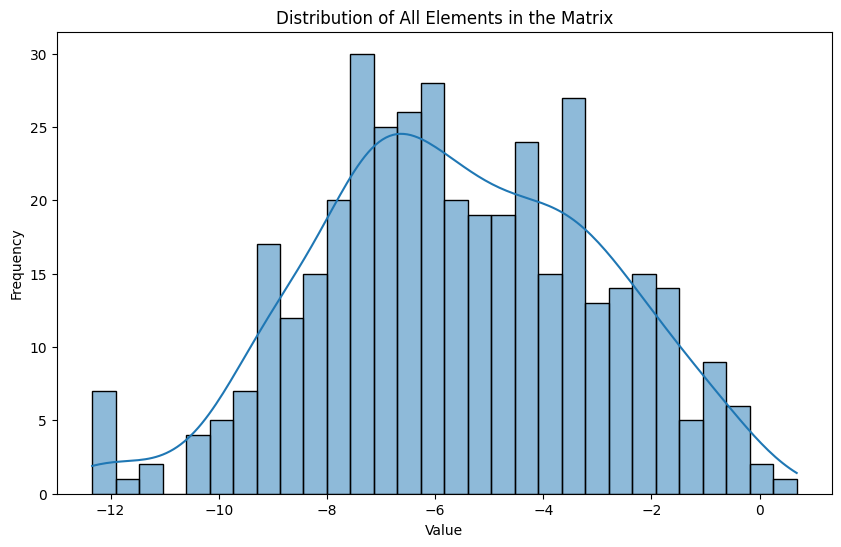

In [21]:
def dist_plot(R):
    flatten_matrix = R[R != np.log(1e-6)].flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(flatten_matrix, kde=True, bins=30)  # KDE adds a smoothed curve over the histogram
    plt.title('Distribution of All Elements in the Matrix')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
dist_plot(R_normalized)

## Training and Test Set Divide

In [22]:
# Obtaining indices of non-empty playtime elements
observed_playtime_elements = matrix_df.stack().index.tolist()

In [23]:
train_indices, test_indices = split_playtime_data(observed_playtime_elements)

Train size: 510, Test size: 30


## Introducing Bias

In [24]:
mean_playtime, user_bias, game_bias = generate_bias(R_normalized, train_indices, user_dict, games_dict)

## Initializing P and Q

In [25]:
P, Q = apply_svd(R_normalized, k=1)
print(P.shape,Q.shape)

(25, 1) (100, 1)


## Stochastic Gradient Descent Algorithm

In [26]:
def SGD(R, P, Q, train_indices, user_dict, games_dict, n_epochs=100, lmbda=0.1, learning_rate=0.001,
       mu = None, bu = None, bi = None):
    """
    Stochastic Gradient Descent (SGD) for Matrix Factorization with L2 Regularization.
    
    Optimized for efficiency.
    
    Parameters:
    - R: User-item matrix with observed playtimes.
    - train_indices: List of (user_id, appid) pairs representing observed training data.
    - P: User latent factor matrix.
    - Q: Item latent factor matrix.
    - n_epochs: Number of iterations.
    - lmbda: L2 regularization strength.
    - learning_rate: Step size for updates.
    
    Returns:
    - Updated P, Q matrices.
    - List of train losses for each epoch.
    """

    if mu is None:
        mu = np.mean(R[np.nonzero(R)])
    if bu is None:
        bu = np.zeros(R.shape[0])
    if bi is None:
        bi = np.zeros(R.shape[1])

    loss = []

    # Precompute index mappings to avoid repeated lookups
    train_indices = np.array([(user_dict[user_id], games_dict[appid]) for user_id, appid in train_indices])

    for e in tqdm(range(n_epochs), desc="Epochs", unit="epoch"):
        total_loss = 0       
        
        for u, i in train_indices:
            error = R[u, i] - ( mu + bu[u] + bi[i] + np.dot(P[u], Q[i]) )

            # Compute loss efficiently (avoiding redundant norm computations)
            total_loss += error**2 + lmbda * (np.dot(P[u], P[u]) + np.dot(Q[i], Q[i]) + bu[u]**2 + bi[i]**2)

            # Update P and Q using efficient NumPy operations
            P[u] += learning_rate * (error * Q[i] - lmbda * P[u])
            Q[i] += learning_rate * (error * P[u] - lmbda * Q[i])
            bu[u] += learning_rate * (error - lmbda * bu[u])
            bi[i] += learning_rate * (error - lmbda * bi[i])

        loss.append(total_loss / len(train_indices))
    
    return P, Q, bu, bi, loss

In [27]:
P, Q, bu, bi, loss = SGD(R_normalized, P, Q, train_indices, user_dict, games_dict, mu = mean_playtime, bu = user_bias, bi = game_bias)

Epochs: 100%|█████████████████████████████| 100/100 [00:00<00:00, 128.38epoch/s]


The Final MSE = 8.117307344188639


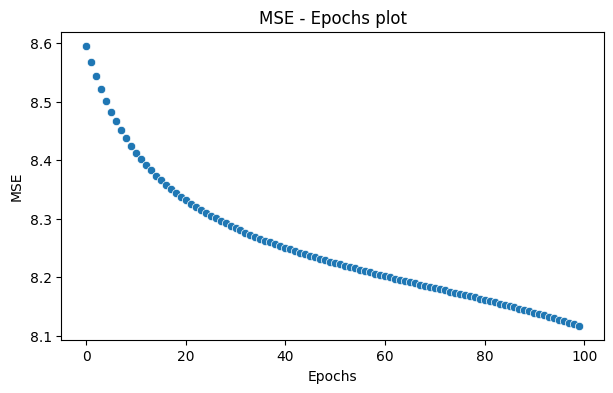

In [29]:
def plot_error_epoch(): 
    x=range(len(loss))
    y=loss
    # graph
    fig,ax1=plt.subplots(1,1,figsize=(7,4))
    sns.scatterplot(x=x,y=y,ax=ax1)
  
    ax1.set_title('MSE - Epochs plot')
    ax1.set(xlabel='Epochs',ylabel='MSE')

    # the final mse
    final_mse=min(loss)
    print(f'The Final MSE = {final_mse}')

# plot
final_mse=plot_error_epoch()

In [30]:
estimated_R = reconstruct_r(P, Q)

In [31]:
mse(R_normalized, estimated_R, test_indices, user_dict, games_dict)

65.67614319614161

## Prediction
The function `recommend_by_user` returns the users top 10 most played games in minutes (as the first dict) and the recommended top 20 in this case along with their normalized playtime prediction. 

In [32]:
prediction_R = prediction_matrix(estimated_R, matrix_df, train_indices, test_indices, user_dict, games_dict)

In [34]:
recommend_by_user(76561198084318972, prediction_R, 20, observed_playtime_elements, appid_to_name, user_dict, games_dict)

{'Path of Exile': 0.05394668625482761,
 'ARK: Survival Evolved': 0.02617829450895285,
 'Brawlhalla': -0.0034010913664168224,
 'Grand Theft Auto V Legacy': -0.006919085739799489,
 'Robocraft': -0.006977763839142184,
 'Cities: Skylines': -0.008378676012297318,
 'Archeblade': -0.008641054942556214,
 'Paladins': -0.009544595934283683,
 'Counter-Strike: Source': -0.018211885606638417,
 'Magicka: Wizard Wars': -0.019353416528112493,
 "Don't Starve": -0.022276438057465566,
 'Russian Fishing 4': -0.02299285686379554,
 'Hacknet': -0.02462343655799263,
 'Business Tour - Online Multiplayer Board Game': -0.02611160323331856,
 'ARK: Survival Of The Fittest': -0.026893190261072123,
 'Fallout 4': -0.027108172984721502,
 'PlanetSide 2 - Test': -0.029451226360735907,
 'Hotline Miami': -0.029681609067339822,
 'Overcooked! 2': -0.03255271551118537,
 'Tabletop Simulator': -0.03282188508789068}

## Importing Trained Model

In [43]:
# Load the variables from the pickle file
with open('recommender_inputs.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Access the individual variables from the loaded dictionary
prediction_R = loaded_data['prediction_R']
observed_playtime_elements = loaded_data['observed_playtime_elements']
appid_to_name = loaded_data['appid_to_name']
user_dict = loaded_data['user_dict']
games_dict = loaded_data['games_dict']
top_10_owned = loaded_data['top_10_owned']

In [44]:
recommend_by_user(76561198059056914, prediction_R, 20, observed_playtime_elements, appid_to_name, user_dict, games_dict)

{'Destiny 2': 3.6310526820638525,
 'Warhammer 40,000: Darktide': 3.3220071656910406,
 'Remnant II': 3.125645838291094,
 "Marvel's Midnight Suns": 3.112248361054699,
 'Crusader Kings III': 3.0366999842659483,
 'Artifact Classic': 3.01967670659118,
 'MechWarrior 5: Mercenaries': 3.000790069554316,
 'Empyrion - Galactic Survival': 2.9947759550816357,
 'HUMANKIND™': 2.94300658085279,
 "Tiny Tina's Wonderlands": 2.940674833032602,
 'Victoria 3': 2.9396326662188805,
 'Lost Ark': 2.8782365122608597,
 'Black Desert SA (Retired)': 2.8573614383184536,
 'Naval Action': 2.839961437879285,
 'Pathfinder: Wrath of the Righteous - Enhanced Edition': 2.7729220427988195,
 'Coral Island': 2.770846313785582,
 'Warframe': 2.7146277928890488,
 'Last Oasis': 2.669510605685711,
 'Hardspace: Shipbreaker': 2.6331036125877785,
 'Warhammer 40,000: Chaos Gate - Daemonhunters': 2.6265226144508254}

In [45]:
top_10_owned[76561198059056914]

{'Counter-Strike 2': 127206.0,
 'MORDHAU': 30741.0,
 'Dota 2': 29757.0,
 "Sid Meier's Civilization VI": 19788.0,
 'Deadlock': 15371.0,
 'Slay the Spire': 11374.0,
 'THE FINALS': 8970.0,
 'Divinity: Original Sin 2': 8447.0,
 "Sid Meier's Civilization V": 8422.0,
 'HELLDIVERS™ 2': 8268.0}